In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, Input
from tensorflow.keras.layers import Concatenate, Activation, Dot
from tensorflow.keras.layers import Lambda, RepeatVector, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K
from tensorflow import keras
import pathlib

In [2]:
def softmax_over_time(x):
    assert(K.ndim(x) > 2) #checks to see if it is higher than 2 dimensions
    #exp and over T in dimension N x T x D
    # max of all T in each N X D
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    
    # sum of all T in each N X D
    s = K.sum(e, axis=1, keepdims=True)
    return e/s

In [3]:
BATCH_SIZE = 64
EPOCHS = 200
LATENT_DIM = 256
LATENT_DIM_DECODER = 256
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [4]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

In [5]:
input_texts = []
target_texts = []
target_texts_inputs = []
t = 0
for line in open(text_file, encoding='utf-8'):
    t+=1
    if t > NUM_SAMPLES:
        break
        
    if '\t' not in line:#if input and target are not seperated
        continue
        
    #split    
    input_text, translation = line.split("\t")
    
    target_text = translation.replace("\n", "") + ' <eos>'
    target_text_input ='<sos> '+ translation.replace("\n", "")
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
print('num samples:', len(input_texts))

num samples: 10000


# ENCODER Inputs Transformation

In [6]:
#input text of the encoder
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [7]:
word2idx_inputs = tokenizer_inputs.word_index
print("Found %s unique input tokens." %len(word2idx_inputs))

Found 2367 unique input tokens.


In [8]:
max_len_input = max(len(s) for s in input_sequences)

In [9]:
#pad sequences for text in encoder
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape: ", encoder_inputs.shape)
print("encoder_data[0] : ", encoder_inputs[0])

encoder_data.shape:  (10000, 5)
encoder_data[0] :  [ 0  0  0  0 15]


# Decoder Target and Decoder Input Targets
# Transformations

In [10]:
tokenizer_outputs = Tokenizer(num_words = MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
#translation for decoder target_texts
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
#translation for decoder input_texts
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [11]:
word2idx_outputs = tokenizer_outputs.word_index
print("Found %s unique token ouputs." %len(word2idx_outputs))

Found 6325 unique token ouputs.


In [12]:
num_words_output = len(word2idx_outputs) + 1

In [13]:
max_len_target = max(len(s) for s in target_sequences)

# Padding decoder Inputs of translation

In [14]:
#the decoder input test <SOS> padded which are the target also
# this is use for teacher forcing
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target,
                              padding='post')
print("decoder_data.shape: ", decoder_inputs.shape)
print("decoder_data[0] : ", decoder_inputs[0])

decoder_data.shape:  (10000, 9)
decoder_data[0] :  [   2 1491    0    0    0    0    0    0    0]


# Target for Decoder padding

In [15]:
#the decoder target text ends in <EOS> which are similar to input of decoder
# difference is that it ends with <eos> instead of the <sos> which is at start
decoder_targets= pad_sequences(target_sequences, maxlen=max_len_target,
                              padding='post')

# Pretrained Embedding

In [16]:
print("Loading word vectors...")
word2vec = {}
with open("glove.6B.%sd.txt" %EMBEDDING_DIM, encoding="utf-8") as f:
    
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

print("Found %s word vectors." %len(word2vec)) #dictonary

Loading word vectors...
Found 400000 word vectors.


In [17]:
print("FIlling pre traineed embeddings...")
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

FIlling pre traineed embeddings...


# Create Embedding layer with
# Pretrained weights

In [18]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=max_len_target,
    #trainable=True
)

# Encoder Train Model

In [19]:
# build the model encoder
#input of the english inputs for the encoder
encoder_inputs_placeholder = Input(shape=(max_len_input,))

#embedding_layer is word2vec pretrained embedding
x = embedding_layer(encoder_inputs_placeholder)

#LATENT_DIM is the hidden_neurons in the lstm
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, dropout=0.5))
#output of 2M, M=LATENT_DIM

#grab the output of multiple hidden_states becuase of return_sequence=True
encoder_outputs = encoder(x)

# Decoder Train Model

In [20]:
#input of the spanish inputs for the decoder
# max_len_target = T
decoder_inputs_placeholder = Input(shape=(max_len_target,))

#new embedding layer with the dimensionality for spanish embedding
#num_words_output = V, Embedding_dim = D represent weight matrix = (V,D)
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM) 

# output of the embedding is N x T x D
# N = number of samples, T=length of sentence, D = neurons in layer
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# Attention

In [21]:
#reusable layers for the loop but have no value for now
#repeat same weight Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)

#last dimension has the output important values that are added
#last dimension is LATENT_DIM which as we recall is M and h from
# encoder has 2M as output
# s(t-1) is M  for the decoder lstm so adding both 2M and M 
# which is the last dimension
attn_concat_layer = Concatenate(axis=-1) #concatenate in the last dimension

attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
 # perform the weighted sum of alpha[t] * h[t] to get context
attn_dot = Dot(axes=1) #vector

In [22]:
#function that will use previous layers
def one_step_attention(h,st_1):
    
    #copy s(t-1) Tx times
    #shape = (Tx, Latent_dim_decoder)
    st_1 = attn_repeat_layer(st_1)
    
    #concaternat all h(t)'s with s(t-1)
    #shape  (Tx, Latent_dim_decoder + Latent_dim *2)
    #sum over the axis=1 which is the sum of the columns for each row
    x = attn_concat_layer([h, st_1])
    
    #neural net first layer with tanh
    x = attn_dense1(x)
    
    #neural net second layer with special softmax over time
    alphas = attn_dense2(x)
    
    #dot for the alphas and the hidden_states h's
    context = attn_dot([alphas, h])
    
    return context

# After Attention
# LSTM implementation

In [23]:
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax') #softmax

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')

#adding all vaues in the third dimension for each row and column
context_last_word_concat_layer = Concatenate(axis=2)#teacher forcing

In [24]:
#will be re-assigned for each iteration of the loop
s = initial_s
c = initial_c

In [25]:
#output collection
outputs=[]
for t in range(max_len_target): #Ty times for the output
    
    #get the context using attention funciton
    #encoder_outputs is the output of the bidirectional lstm
    #bidirectional with return_sequence returns multiple hidden_states
    context = one_step_attention(encoder_outputs, s)
    
    #allows us to get a new word embeded for teacher forcing
    #this is a lambda layer different to a regular lambda
    selector = Lambda(lambda x: x[:, t:t+1]) #new word
    
    #input the decoder_input_x which outputs the embedding of 
    #sequence which is the each word in a sentence but we pick
    #one word at the time with the selector lambda
    xt = selector(decoder_inputs_x)
    
    #combine for teacher forcing and is ready to be use as
    # the input of the lstm in decoder
    decoder_lstm_input = context_last_word_concat_layer([context, xt])
    
    #pass in the combine [context, last word] into the lstm
    #one word at a time xt which is for teacher forcing
    #with the [s, c] states
    # get new output, s and c
    o,s,c = decoder_lstm(decoder_lstm_input, initial_state=[s,c])
    
    #final dense layer to get the nexxt word prediction
    decoder_outputs = decoder_dense(o) #softmax
    
    #add the output the outputs list
    outputs.append(decoder_outputs)

In [26]:
def stack_and_transpose(x):
    #x is a list of lenght T, each element is a
    # batch_size x output_vocab_size tensor (b,V)
    x = K.stack(x) #is now  T x b x V 
    
    #batch_size x T x V 
    # b x T x V
    # allows to change where each dimension should be with its values
    x = K.permute_dimensions(x, pattern=(1,0,2))
    return x
    

In [27]:
#make it into a layer 
#faster for layer formation will be Permute from layers
stacker = Lambda(stack_and_transpose)
#this is the last layer of the model
outputs = stacker(outputs) # we insert the list so it can stack as a sequence

# Creating Model

In [28]:
model = Model(
    #place holders for inputs start of model first layer
    inputs=[
        encoder_inputs_placeholder,
        decoder_inputs_placeholder,
        initial_s,
        initial_c,
    ],
    
    #output of the last layer of the model
    outputs=outputs
)

In [29]:
model.compile(
    optimizer='Adam',
    loss ='SparseCategoricalCrossentropy',
    metrics=["accuracy"]
)

In [30]:
z = np.zeros((NUM_SAMPLES, LATENT_DIM_DECODER)) #initial [s,c]
r = model.fit(
    [encoder_inputs, decoder_inputs, z, z], decoder_targets,
    batch_size = BATCH_SIZE,
    epochs= EPOCHS,
    validation_split = 0.2
)

Epoch 1/200
125/125 [==============================] - 57s 293ms/step - loss: 3.2766 - accuracy: 0.5885 - val_loss: 3.0676 - val_accuracy: 0.5573
Epoch 2/200
125/125 [==============================] - 31s 251ms/step - loss: 2.4893 - accuracy: 0.6334 - val_loss: 3.0098 - val_accuracy: 0.5914
Epoch 3/200
125/125 [==============================] - 32s 254ms/step - loss: 2.3974 - accuracy: 0.6442 - val_loss: 2.9899 - val_accuracy: 0.6028
Epoch 4/200
125/125 [==============================] - 32s 253ms/step - loss: 2.3345 - accuracy: 0.6515 - val_loss: 2.9779 - val_accuracy: 0.5992
Epoch 5/200
125/125 [==============================] - 32s 254ms/step - loss: 2.2830 - accuracy: 0.6552 - val_loss: 2.9208 - val_accuracy: 0.6051
Epoch 6/200
125/125 [==============================] - 32s 255ms/step - loss: 2.2306 - accuracy: 0.6593 - val_loss: 2.8535 - val_accuracy: 0.6137
Epoch 7/200
125/125 [==============================] - 32s 259ms/step - loss: 2.1710 - accuracy: 0.6662 - val_loss: 2.8152 -

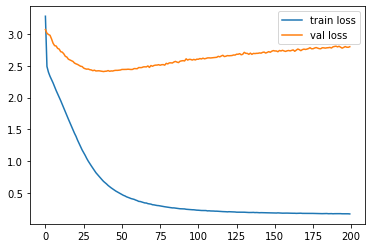

In [31]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

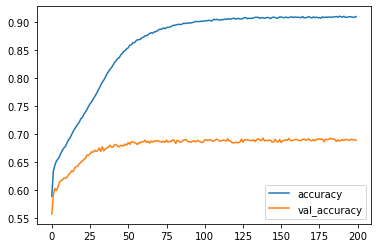

In [32]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history["val_accuracy"], label='val_accuracy')
plt.legend()
plt.show()

# Encoder and Decoder Testing

In [33]:
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

In [37]:
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [39]:
context = one_step_attention(encoder_outputs_as_input, initial_s)

In [42]:
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

In [44]:
o,s,c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o) #softmax

In [45]:
decoder_model = Model(
    inputs=[
        decoder_inputs_single,
        encoder_outputs_as_input,
        initial_s,
        initial_c
    ],
    outputs=[decoder_outputs, s, c]
)

In [46]:
#real words
idx2word_eng = {v:k for k,v in word2idx_inputs.items()}
idx2word_trans = {v:k for k,v in word2idx_outputs.items()}

In [48]:
def decoder_sequence(input_seq):
    #encode the input as state vectors
    enc_out = encoder_model.predict(input_seq)
    
    #empty target for first sequence
    target_seq = np.zeros((1,1))
    
    target_seq[0,0] = word2idx_outputs['<sos>']
    
    #if we get the end break
    eos = word2idx_outputs['<eos>']
    
    s = np.zeros((1, LATENT_DIM_DECODER))
    c = np.zeros((1, LATENT_DIM_DECODER))
    
    output_sentence = []
    for _ in range(max_len_target):
        #return output hidden state and cell state
        o, s, c =decoder_model.predict([target_seq, enc_out, s, c])
        
        idx = np.argmax(o.flatten())
        
        if eos == idx:
            break
            
        word=''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)
            
        target_seq[0,0] = idx
        
    return ' '.join(output_sentence)

    

In [50]:
while True:
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decoder_sequence(input_seq)
    print("_")
    print("Input: ", input_texts[i])
    print("Translation:", translation)
    
    ans = input("Continue? Y/n: ")
    if ans and ans.lower().startswith('n'):
        break

1/1 [==============================] - 0s 23ms/step
_
Input:  Go slow.
Translation: vaya despacio.
Continue? Y/n: y
1/1 [==============================] - 0s 23ms/step
_
Input:  I'm not bossy.
Translation: no soy mandón.
Continue? Y/n: y
1/1 [==============================] - 0s 23ms/step
_
Input:  What a night!
Translation: ¡qué noche!
Continue? Y/n: y
1/1 [==============================] - 0s 25ms/step
_
Input:  He scolded her.
Translation: él la
Continue? Y/n: y
1/1 [==============================] - 0s 25ms/step
_
Input:  I just got up.
Translation: recién me acabo levantar. levantar.
Continue? Y/n: y
1/1 [==============================] - 0s 23ms/step
_
Input:  I'll be working.
Translation: voy a
Continue? Y/n: y
1/1 [==============================] - 0s 24ms/step
_
Input:  Which key is it?
Translation: ¿cómo de pequeño es?
Continue? Y/n: y
1/1 [==============================] - 0s 24ms/step
_
Input:  Help is coming.
Translation: la ayuda está llegando.
Continue? Y/n: y
1/1 [=====